<div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/0/08/Netflix_2015_logo.svg" width="300">
</div>

# Netflix Global Top 10 Performance Predictor: Forecasting Success from Early Rankings with Machine Learning

We analyse the Netflix Global Top 10 weekly dataset and build machine learning models (Random Forest, Decision Tree, Gradient Boosting, and XGBoost) to predict a title's future performance based on its first two weeks in the rankings. We evaluate and compare the performance of these models against a previously developed [multiple linear regression model](https://www.kaggle.com/code/davidpbriggs/netflix-global-top-10-performance-predictor).

## 1 Imports
We import relevant Python packages for data manipulation, visualisation, preprocessing and modeling.

In [1]:
# Operational packages
import pandas as pd
import numpy as np
import pickle
import warnings

# Visualisation packages
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor  

# Model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

We load the Netflix Global Top 10 weekly dataset into a pandas DataFrame and store it in the variable **top10_global_weekly**.

In [2]:
# Import TSV file into DataFrame
top10_global_weekly = pd.read_csv('../input/2025-03-07_global_weekly.tsv', sep='\t')

## 2 Data Exploration

### 2.1 Explore data with EDA

#### 2.1.1 Netflix Global Top 10 Weekly Dataset

We display the first 10 rows of the DataFrame.

In [3]:
# Display first 10 rows
top10_global_weekly.head()

,week,category,weekly_rank,show_title,season_title,weekly_hours_viewed,runtime,weekly_views,cumulative_weeks_in_top_10,is_staggered_launch,runtime_override_flag,episode_launch_dtls
0,2025-03-02,Films (English),1,Venom: The Last Dance,NaN,23300000,1.8167,12800000.0,1,False,"[{is_staggered_launch=0, is_live_title=0}]",NaN
1,2025-03-02,Films (English),2,Despicable Me 4,NaN,13800000,1.5667,8800000.0,1,False,"[{is_staggered_launch=0, is_live_title=0}]",NaN
2,2025-03-02,Films (English),3,Despicable Me 3,NaN,10300000,1.5000,6900000.0,7,False,"[{is_staggered_launch=0, is_live_title=0}]",NaN
3,2025-03-02,Films (English),4,Minions,NaN,9000000,1.5167,5900000.0,12,False,"[{is_staggered_launch=0, is_live_title=0}]",NaN
4,2025-03-02,Films (English),5,Uncharted,NaN,10100000,1.9333,5200000.0,5,False,"[{is_staggered_launch=0, is_live_title=0}]",NaN


In [4]:
# Get basic information
top10_global_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7680 entries, 0 to 7679
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   week                        7680 non-null   object 
 1   category                    7680 non-null   object 
 2   weekly_rank                 7680 non-null   int64  
 3   show_title                  7680 non-null   object 
 4   season_title                3711 non-null   object 
 5   weekly_hours_viewed         7680 non-null   int64  
 6   runtime                     3600 non-null   float64
 7   weekly_views                3600 non-null   float64
 8   cumulative_weeks_in_top_10  7680 non-null   int64  
 9   is_staggered_launch         7680 non-null   bool   
 10  runtime_override_flag       3600 non-null   object 
 11  episode_launch_dtls         127 non-null    object 
dtypes: bool(1), float64(2), int64(3), object(6)
memory usage: 667.6+ KB


In [5]:
# Generate basic descriptive stats
top10_global_weekly.describe()

,weekly_rank,weekly_hours_viewed,runtime,weekly_views,cumulative_weeks_in_top_10
count,7680.000000,7.680000e+03,3600.000000,3.600000e+03,7680.000000
mean,5.500000,1.796999e+07,3.614009,4.702222e+06,3.121745
std,2.872468,2.588482e+07,3.022567,5.381986e+06,3.275340
min,1.000000,7.000000e+05,0.000000,6.000000e+05,1.000000
25%,3.000000,6.067500e+06,1.683300,1.800000e+06,1.000000
50%,5.500000,1.102500e+07,2.166700,3.100000e+06,2.000000
75%,8.000000,2.010750e+07,5.150000,5.300000e+06,4.000000
max,10.000000,5.717600e+08,23.366700,6.800000e+07,30.000000


We check the data types of the columns.

In [6]:
# Check datatypes
top10_global_weekly.dtypes

week                           object
category                       object
weekly_rank                     int64
show_title                     object
season_title                   object
weekly_hours_viewed             int64
runtime                       float64
weekly_views                  float64
cumulative_weeks_in_top_10      int64
is_staggered_launch              bool
runtime_override_flag          object
episode_launch_dtls            object
dtype: object

We convert **week** to a pandas datetime64 type for easier time-based analysis.

In [7]:
# Convert week column to datetime
top10_global_weekly['week']  = pd.to_datetime(top10_global_weekly['week'])

We convert **cumulative_weeks_in_top_10** and **weekly_hours_viewed** to float data types.

In [8]:
# Convert cumulative weeks and weekly hours viewed to float
top10_global_weekly['cumulative_weeks_in_top_10'] = top10_global_weekly['cumulative_weeks_in_top_10'].astype(float)
top10_global_weekly['weekly_hours_viewed'] = top10_global_weekly['weekly_hours_viewed'].astype(float)

We check for missing values.

In [9]:
# Check for missing values
top10_global_weekly.isnull().sum()

week                             0
category                         0
weekly_rank                      0
show_title                       0
season_title                  3969
weekly_hours_viewed              0
runtime                       4080
weekly_views                  4080
cumulative_weeks_in_top_10       0
is_staggered_launch              0
runtime_override_flag         4080
episode_launch_dtls           7553
dtype: int64

We replace **season_title** with **show_title** where **season_title** has a null value.

In [10]:
# Replace null values in season_title with corresponding values from show_title
top10_global_weekly['season_title'] = top10_global_weekly['season_title'].fillna(top10_global_weekly['show_title'])

We drop the columns **runtime**, **weekly_views**, **runtime_override_flag** and **episode_launch_dtls** due to a high proportion of null values. This is likely a result of changes in Netflix's data collection methods.

In [11]:
# Drop columns with large number of null values
subset_top10_global_weekly = top10_global_weekly.drop(columns=['runtime', 'weekly_views', 'runtime_override_flag', 'episode_launch_dtls'])
subset_top10_global_weekly.isnull().sum()

week                          0
category                      0
weekly_rank                   0
show_title                    0
season_title                  0
weekly_hours_viewed           0
cumulative_weeks_in_top_10    0
is_staggered_launch           0
dtype: int64

We check for duplicate entries and remove them if necessary.

In [12]:
# Check for duplicates
subset_top10_global_weekly.duplicated().sum()

0

In [13]:
# Drop duplicates
subset_top10_global_weekly.drop_duplicates().reset_index(drop=True)

,week,category,weekly_rank,show_title,season_title,weekly_hours_viewed,cumulative_weeks_in_top_10,is_staggered_launch
0,2025-03-02,Films (English),1,Venom: The Last Dance,Venom: The Last Dance,23300000.0,1.0,False
1,2025-03-02,Films (English),2,Despicable Me 4,Despicable Me 4,13800000.0,1.0,False
2,2025-03-02,Films (English),3,Despicable Me 3,Despicable Me 3,10300000.0,7.0,False
3,2025-03-02,Films (English),4,Minions,Minions,9000000.0,12.0,False
4,2025-03-02,Films (English),5,Uncharted,Uncharted,10100000.0,5.0,False
...,...,...,...,...,...,...,...,...
7675,2021-07-04,TV (Non-English),6,Elite,Elite: Season 1,10530000.0,1.0,False
7676,2021-07-04,TV (Non-English),7,Elite,Elite: Season 3,10200000.0,1.0,False
7677,2021-07-04,TV (Non-English),8,Elite,Elite: Season 2,10140000.0,1.0,False
7678,2021-07-04,TV (Non-English),9,Katla,Katla: Season 1,9190000.0,1.0,False


#### 2.1.2 DataFrame for Modeling

We create a new DataFrame for modeling and store it in the variable **summary_top10_global_weekly**. We group the weekly data by **season_title**, aggregating key metrics such as **total_hours_viewed_in_top_10** and **total_weeks_in_top_10**. Additionally we capture **weekly_hours_viewed** and **weekly_rank** for the title's first two weeks in Netflix's Global Top 10. For titles that remain in the rankings for only one week, we set **week2_hours_viewed** as 0 and **week2_rank** as 11.

In [14]:
# Sort by date
subset_top10_global_weekly = subset_top10_global_weekly.sort_values(by='week', ascending=True)

# Group by 'season_title' and aggregate the data
summary_top10_global_weekly = subset_top10_global_weekly.groupby('season_title').agg(
    show_title=('show_title', 'first'),
    category=('category', 'first'),
    total_hours_viewed_in_top_10=('weekly_hours_viewed', 'sum'),
    total_weeks_in_top_10=('cumulative_weeks_in_top_10', 'max'),
    is_staggered_launch=('is_staggered_launch', 'first'),
    week1_hours_viewed=('weekly_hours_viewed', 'first'),
    week1_rank=('weekly_rank', 'first'),
    week2_hours_viewed=('weekly_hours_viewed', lambda x: x.iloc[1] if len(x) > 1 else 0),
    week2_rank=('weekly_rank', lambda x: x.iloc[1] if len(x) > 1 else 11)
).reset_index()

# Sort by total hours viewed
summary_top10_global_weekly = summary_top10_global_weekly.sort_values(by='total_hours_viewed_in_top_10', ascending=False).reset_index(drop=True)
summary_top10_global_weekly.head()

,season_title,show_title,category,total_hours_viewed_in_top_10,total_weeks_in_top_10,is_staggered_launch,week1_hours_viewed,week1_rank,week2_hours_viewed,week2_rank
0,Squid Game: Season 1,Squid Game,TV (Non-English),2.664700e+09,29.0,False,63190000.0,1,448730000.0,1
1,Stranger Things 4,Stranger Things,TV (English),1.887310e+09,19.0,False,286790000.0,1,335010000.0,1
2,Wednesday: Season 1,Wednesday,TV (English),1.806850e+09,20.0,False,341230000.0,1,411290000.0,1
3,Squid Game: Season 2,Squid Game,TV (Non-English),1.353300e+09,10.0,False,487600000.0,1,417100000.0,1
4,Bridgerton: Season 2,Bridgerton,TV (English),1.027000e+09,22.0,False,193020000.0,1,251740000.0,1


We plot a line graph showing the weekly viewing of all 7,680 Netflix Global Top 10 titles, labeling the three most popular.

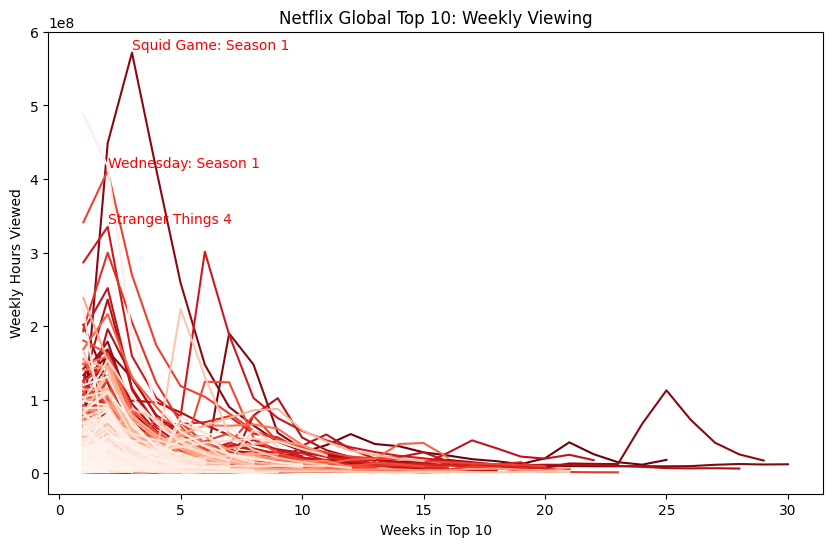

In [15]:
# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Get the most viewed titles
most_viewed_titles = summary_top10_global_weekly['season_title'].head(3)

# Set up the plot size
plt.figure(figsize=(10, 6))

# Create the line plot
sns.lineplot(data=subset_top10_global_weekly, 
             x='cumulative_weeks_in_top_10', 
             y='weekly_hours_viewed', 
             hue='season_title',
             legend=False,
             palette="Reds_r")

# Annotate the the most viewed titles
for title in most_viewed_titles:
    # Filter the data for the current title
    title_data = subset_top10_global_weekly[subset_top10_global_weekly['season_title'] == title]
    
    # Get the row with the maximum 'weekly_hours_viewed'
    peak_row = title_data.loc[title_data['weekly_hours_viewed'].idxmax()]
    
    # Annotate the plot with the season title at the peak of weekly_hours_viewed
    plt.text(peak_row['cumulative_weeks_in_top_10'],
             peak_row['weekly_hours_viewed'],
             title,
             fontsize=10,
             ha='left',
             va='bottom',
             color='red')

# Add labels and title
plt.title('Netflix Global Top 10: Weekly Viewing')
plt.xlabel('Weeks in Top 10')
plt.ylabel('Weekly Hours Viewed')

# Save the plot as a PNG file
plt.savefig('netflix_global_top_10_weekly.png', format='png')

# Display the plot
plt.show()

We plot a bar chart showing the total hours viewed of the most popular Netflix Global Top 10 titles.

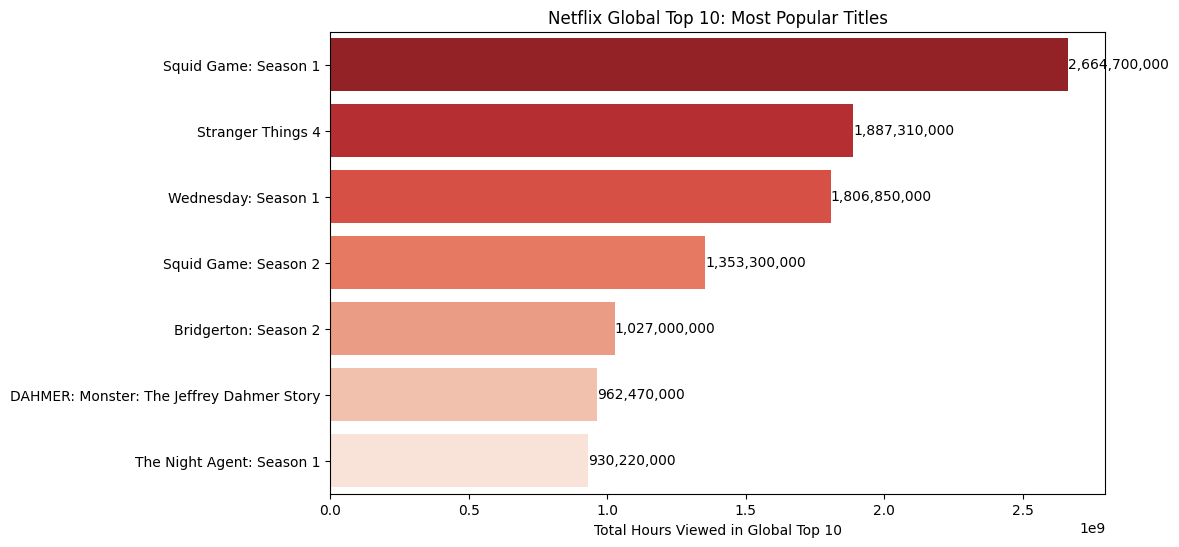

In [16]:
# Create the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x="total_hours_viewed_in_top_10", 
    y="season_title", 
    data=summary_top10_global_weekly.head(7), 
    palette="Reds_r"
)

# Add labels on the bars
for index, value in enumerate(summary_top10_global_weekly.head(7)['total_hours_viewed_in_top_10']):
    ax.text(value, index, f"{value:,.0f}", va='center')

# Set labels and title
plt.xlabel("Total Hours Viewed in Global Top 10")
plt.ylabel("")
plt.title("Netflix Global Top 10: Most Popular Titles")

# Save the plot as a PNG file
plt.savefig('netflix_global_top_10_total_hours_viewed.png', format='png', bbox_inches='tight')

# Display the plot
plt.show()

We plot a bar chart showing the titles that spent the most weeks in the Netflix Global Top 10.

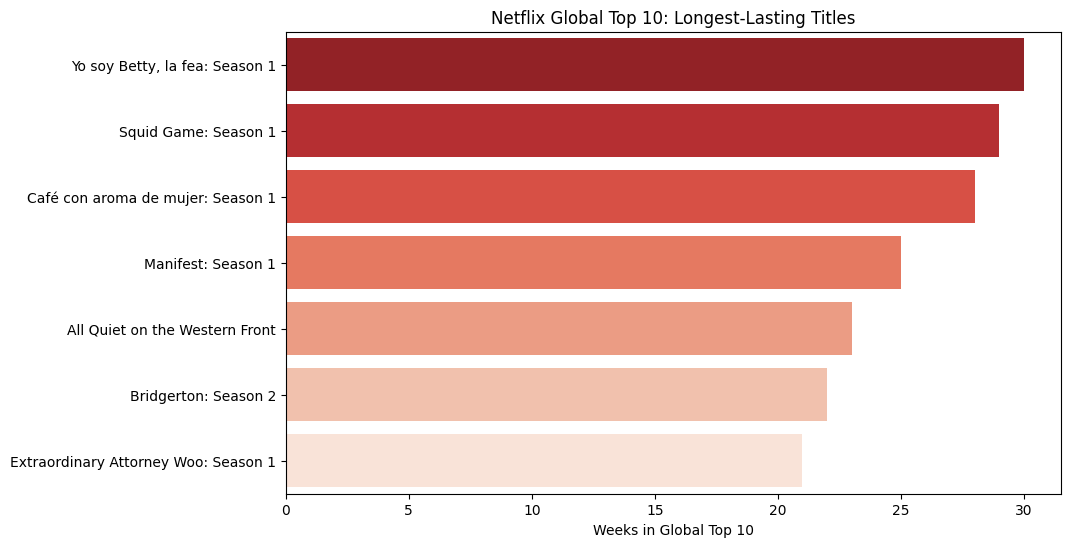

In [17]:
# Create the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x="total_weeks_in_top_10", 
    y="season_title", 
    data=summary_top10_global_weekly.sort_values(by='total_weeks_in_top_10', ascending=False).head(7), 
    palette="Reds_r"
)

# Set labels and title
plt.xlabel("Weeks in Global Top 10")
plt.ylabel("")
plt.title("Netflix Global Top 10: Longest-Lasting Titles")

# Save the plot as a PNG file
plt.savefig('netflix_global_top_10_total_weeks.png', format='png', bbox_inches='tight')

# Display the plot
plt.show()

We check summary information for the new DataFrame.

In [18]:
# Check summary info
summary_top10_global_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2759 entries, 0 to 2758
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   season_title                  2759 non-null   object 
 1   show_title                    2759 non-null   object 
 2   category                      2759 non-null   object 
 3   total_hours_viewed_in_top_10  2759 non-null   float64
 4   total_weeks_in_top_10         2759 non-null   float64
 5   is_staggered_launch           2759 non-null   bool   
 6   week1_hours_viewed            2759 non-null   float64
 7   week1_rank                    2759 non-null   int64  
 8   week2_hours_viewed            2759 non-null   float64
 9   week2_rank                    2759 non-null   int64  
dtypes: bool(1), float64(4), int64(2), object(3)
memory usage: 196.8+ KB


We analyse descriptive statistics.

In [19]:
# Get descriptive stats
summary_top10_global_weekly.describe()

,total_hours_viewed_in_top_10,total_weeks_in_top_10,week1_hours_viewed,week1_rank,week2_hours_viewed,week2_rank
count,2.759000e+03,2759.00000,2.759000e+03,2759.000000,2.759000e+03,2759.000000
mean,5.002157e+07,2.77963,1.626772e+07,5.545487,1.501621e+07,6.686843
std,1.134326e+08,2.62000,2.357384e+07,2.914172,2.814769e+07,3.831827
min,8.000000e+05,1.00000,8.000000e+05,1.000000,0.000000e+00,1.000000
25%,7.900000e+06,1.00000,5.600000e+06,3.000000,0.000000e+00,3.000000
50%,1.806000e+07,2.00000,9.880000e+06,6.000000,6.900000e+06,7.000000
75%,4.769500e+07,3.00000,1.805500e+07,8.000000,1.734000e+07,11.000000
max,2.664700e+09,30.00000,4.876000e+08,10.000000,4.487300e+08,11.000000


We observe that **is_staggered_launch** has an imbalanced distribution and weak correlation with **log_total_hours_viewed_in_top_10**.

### 2.2 Examine correlations
#### 2.2.1 Continuous variables
We examine correlations among the continuous variables.

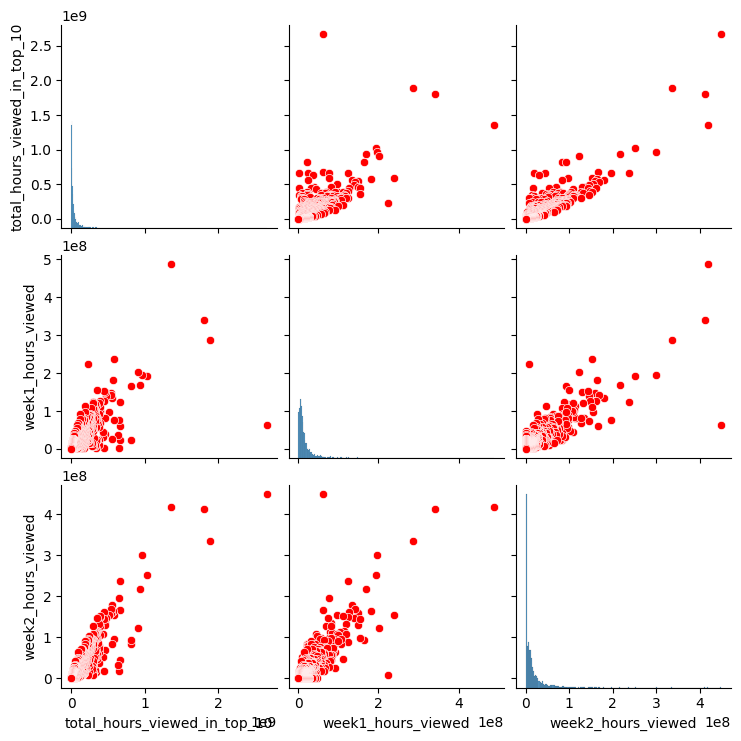

In [20]:
# Create pairwise scatterplots of continuous variables
sns.pairplot(summary_top10_global_weekly[[
             'total_hours_viewed_in_top_10',
             'week1_hours_viewed',
             'week2_hours_viewed']],
             plot_kws={'color': 'red'})

# Show the plot
plt.show()

We observe skewed distributions with the presence of outliers. There is a strong positive correlation between **total_hours_viewed_in_top_10** and both **week1_hours_viewed** and **week2_hours_viewed**. The plots also indicate a strong positive correlation between **week1_hours_viewed** and **week2_hours_viewed**, suggesting potential collinearity that may need to be addressed during modeling.

#### 2.2.2 Categorical variables
We examine correlations involving categorical variables.

<Axes: xlabel='category', ylabel='total_hours_viewed_in_top_10'>

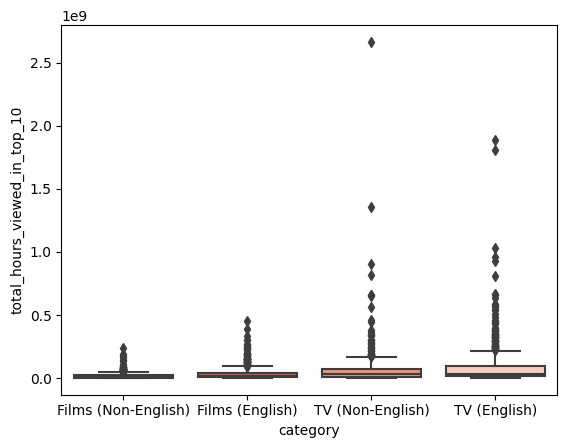

In [21]:
# Define the desired order of categories
category_order = ["Films (Non-English)", "Films (English)", "TV (Non-English)", "TV (English)"]

# Create boxplot to show distribution of 'total_hours_viewed_in_top_10' by 'category'
sns.boxplot(x = "category",
            y = "total_hours_viewed_in_top_10",
            data = summary_top10_global_weekly,
            order=category_order,
            palette='Reds_r')

This plot will be revisited after removing outliers to ensure a clearer interpretation.

#### 2.2.3 Boolean variables
We examine correlations involving Boolean variables.

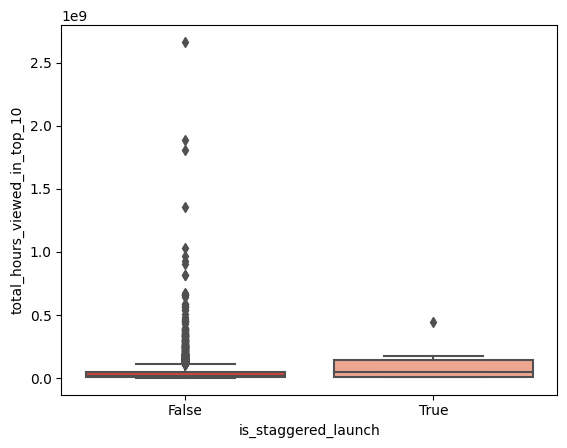

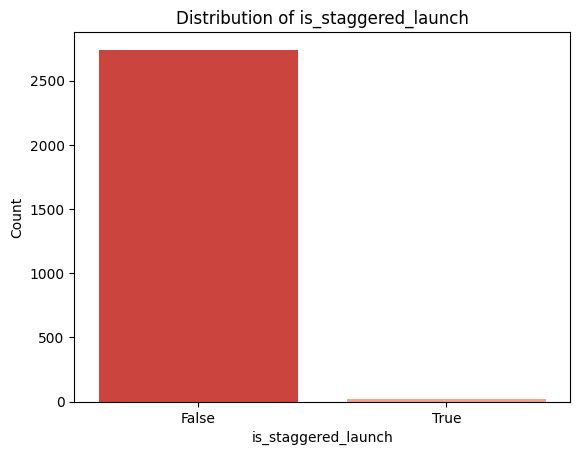

In [22]:
# Create boxplot to show distribution of 'total_hours_viewed_in_top_10' by boolean variable 'is_staggered_launch'
sns.boxplot(x="is_staggered_launch",
            y="total_hours_viewed_in_top_10",
            data=summary_top10_global_weekly,
            palette='Reds_r')
plt.show()

# Check class balance for claim_status
sns.countplot(x='is_staggered_launch',
              data=summary_top10_global_weekly,
              palette='Reds_r')
plt.title("Distribution of is_staggered_launch")
plt.xlabel('is_staggered_launch')
plt.ylabel('Count')
plt.show()

These plots will be revisited after removing outliers to ensure a clearer interpretation.

### 2.3 Feature Engineering

Unlike linear regression, tree-based models do not make assumptions about linearity, normality, or homoscedasticity, and feature scaling is not required.

#### 2.3.1 Numeric variables

We plot a histogram and boxplot to show the distribution of **total_hours_viewed_in_top_10** to assess skewness and detect potential outliers. This will help determine whether transformations or outlier removal are necessary before modeling.

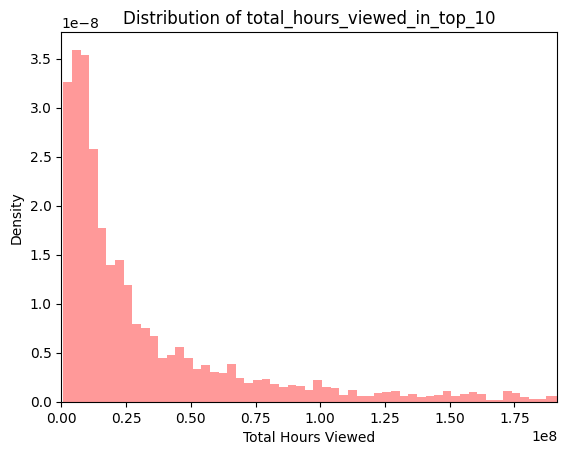

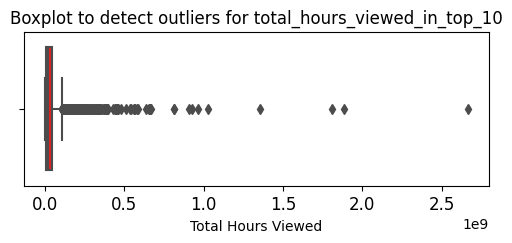

In [23]:
# Calculate the 95th percentile for total hours viewed
percentile95 = summary_top10_global_weekly['total_hours_viewed_in_top_10'].quantile(0.95)

# Create a histogram to visualise distribution of `total_hours_viewed_in_top_10`
plt.hist(summary_top10_global_weekly['total_hours_viewed_in_top_10'], bins=800, density=True, alpha=0.4, color='red')
plt.xlim(0, percentile95)
plt.title("Distribution of total_hours_viewed_in_top_10")
plt.xlabel('Total Hours Viewed')
plt.ylabel('Density')
plt.show()

# Create a boxplot to visualise distribution of `total_hours_viewed_in_top_10`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for total_hours_viewed_in_top_10', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'total_hours_viewed_in_top_10',
            data = summary_top10_global_weekly,
            color="red")
plt.xlabel("Total Hours Viewed")
plt.show()

The distribution is right-skewed, with the average Netflix Global Top 10 title recording 50 million hours, and the maximum at 2.6 billion hours ('Squid Game: Season 1').

While Decision Trees and Random Forests are generally robust to skewed data and outliers, we believe it would still be beneficial to remove outliers. A log transformation is also applied for potential use.

To address this, we remove rows where values fall outside the interquartile range (IQR).

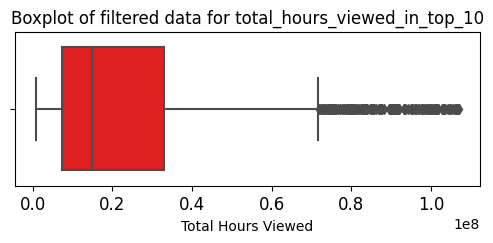

In [24]:
# Check for and handle outliers for total_hours_viewed_in_top_10
# Calculate 25th percentile of video_like_count
percentile25 = summary_top10_global_weekly['total_hours_viewed_in_top_10'].quantile(0.25)

# Calculate 75th percentile of annual strikes
percentile75 = summary_top10_global_weekly['total_hours_viewed_in_top_10'].quantile(0.75)

# Calculate interquartile range
iqr = percentile75 - percentile25

# Calculate upper and lower thresholds for outliers
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# Filter out rows with outliers
filtered_summary_top10_global_weekly = summary_top10_global_weekly[
    (summary_top10_global_weekly['total_hours_viewed_in_top_10'] >= lower_limit) &
    (summary_top10_global_weekly['total_hours_viewed_in_top_10'] <= upper_limit)
]

# Check new distribution
plt.figure(figsize=(6,2))
plt.title('Boxplot of filtered data for total_hours_viewed_in_top_10', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'total_hours_viewed_in_top_10',
            data = filtered_summary_top10_global_weekly,
            color='red')
plt.xlabel("Total Hours Viewed")
plt.show()

We plot a histogram and boxplot to show the distribution of **total_weeks_in_top_10**.

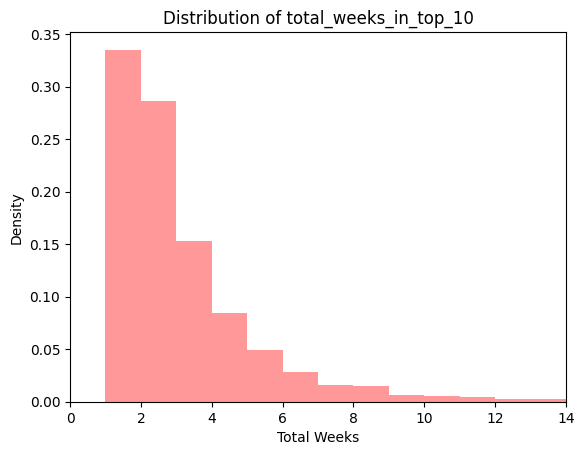

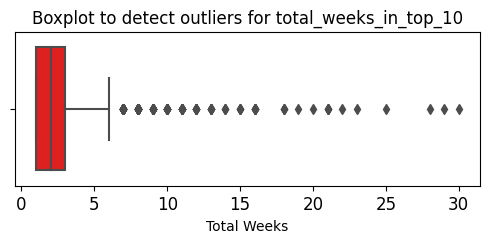

In [25]:
# Calculate the 99th percentile for weeks in Top 10
percentile99 = summary_top10_global_weekly['total_weeks_in_top_10'].quantile(0.99)

# Create a histogram to visualise the distribution of `total_weeks_in_top_10`
bin_width = 1
bins = np.arange(summary_top10_global_weekly['total_weeks_in_top_10'].min(), 
                 summary_top10_global_weekly['total_weeks_in_top_10'].max() + bin_width, 
                 bin_width)
plt.hist(summary_top10_global_weekly['total_weeks_in_top_10'],
         bins=bins,
         density=True,
         alpha=0.4,
         color='red')
plt.xlim(0, percentile99)
plt.title("Distribution of total_weeks_in_top_10")
plt.xlabel('Total Weeks')
plt.ylabel('Density')
plt.show()

# Create a boxplot to visualise the distribution of `total_weeks_in_top_10`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for total_weeks_in_top_10', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'total_weeks_in_top_10',
            data = summary_top10_global_weekly,
            color='red')
plt.xlabel("Total Weeks")
plt.show()

We remove rows where values fall outside the interquartile range (IQR).

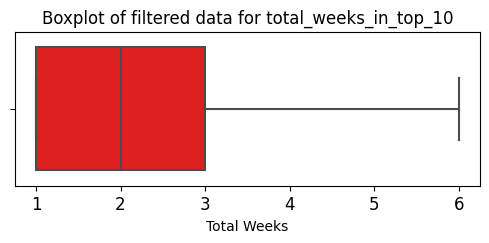

In [26]:
# Check for and handle outliers for total_hours_viewed_in_top_10 in original, untransformed dataset
# Calculate 25th percentile of video_like_count
percentile25 = summary_top10_global_weekly['total_weeks_in_top_10'].quantile(0.25)

# Calculate 75th percentile of annual strikes
percentile75 = summary_top10_global_weekly['total_weeks_in_top_10'].quantile(0.75)

# Calculate interquartile range
iqr = percentile75 - percentile25

# Calculate upper and lower thresholds for outliers
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# Filter out rows with outliers
filtered2_summary_top10_global_weekly = filtered_summary_top10_global_weekly[
    (filtered_summary_top10_global_weekly['total_weeks_in_top_10'] >= lower_limit) &
    (filtered_summary_top10_global_weekly['total_weeks_in_top_10'] <= upper_limit)
]

# Check new distribution
plt.figure(figsize=(6,2))
plt.title('Boxplot of filtered data for total_weeks_in_top_10', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'total_weeks_in_top_10',
            data = filtered2_summary_top10_global_weekly,
            color='red')
plt.xlabel("Total Weeks")
plt.show()

We plot a histogram and boxplot to show the distribution of **week1_hours_viewed**.

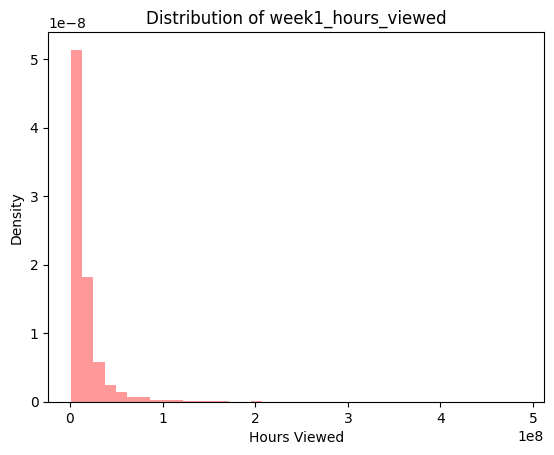

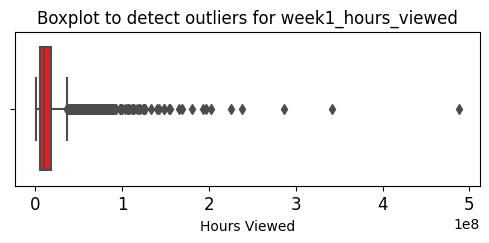

In [27]:
# Create a histogram to visualise the distribution of `week1_hours_viewed`
plt.hist(summary_top10_global_weekly['week1_hours_viewed'],
         bins=40,
         density=True,
         alpha=0.4,
         color='red')
plt.title("Distribution of week1_hours_viewed")
plt.xlabel('Hours Viewed')
plt.ylabel('Density')
plt.show()

# Create a boxplot to visualise the distribution of `week1_hours_viewed`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for week1_hours_viewed', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'week1_hours_viewed',
            data = summary_top10_global_weekly,
            color='red')
plt.xlabel("Hours Viewed")
plt.show()

We remove rows where values fall outside the interquartile range (IQR).

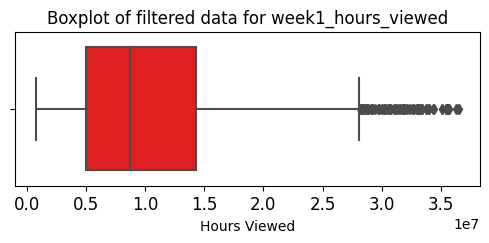

In [28]:
# Check for and handle outliers for log_week1_hours_viewed in original, untransformed dataset
# Calculate 25th percentile of video_like_count
percentile25 = summary_top10_global_weekly['week1_hours_viewed'].quantile(0.25)

# Calculate 75th percentile of annual strikes
percentile75 = summary_top10_global_weekly['week1_hours_viewed'].quantile(0.75)

# Calculate interquartile range
iqr = percentile75 - percentile25

# Calculate upper and lower thresholds for outliers
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# Filter out rows with outliers
filtered3_summary_top10_global_weekly = filtered2_summary_top10_global_weekly[
    (filtered2_summary_top10_global_weekly['week1_hours_viewed'] >= lower_limit) &
    (filtered2_summary_top10_global_weekly['week1_hours_viewed'] <= upper_limit)
]

# Create new boxplot to visualise distribution of transformed variable `week1_hours_viewed`
plt.figure(figsize=(6,2))
plt.title('Boxplot of filtered data for week1_hours_viewed', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'week1_hours_viewed',
            data = filtered3_summary_top10_global_weekly,
            color='red')
plt.xlabel("Hours Viewed")
plt.show()

We plot a histogram and boxplot to show the distribution of **week2_hours_viewed**.

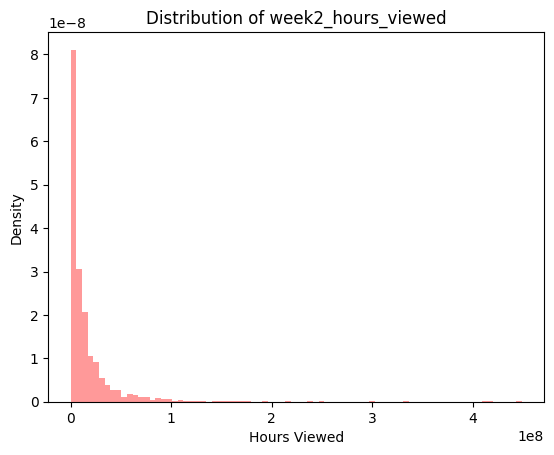

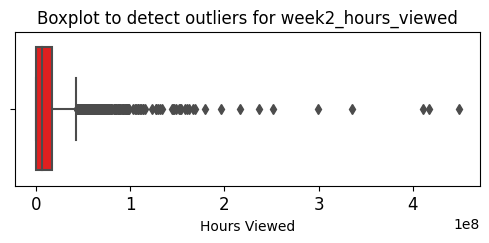

In [29]:
# Create a histogram to visualise the distribution of `week2_hours_viewed`
plt.hist(summary_top10_global_weekly['week2_hours_viewed'],
         bins=80,
         density=True,
         alpha=0.4,
         color='red')
plt.title("Distribution of week2_hours_viewed")
plt.xlabel('Hours Viewed')
plt.ylabel('Density')
plt.show()

# Create a boxplot to visualise the distribution of `week2_hours_viewed`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for week2_hours_viewed', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'week2_hours_viewed',
            data = summary_top10_global_weekly,
            color='red')
plt.xlabel("Hours Viewed")
plt.show()

We remove rows where values fall outside the interquartile range (IQR).

In [30]:
# Check for and handle outliers for week2_hours_viewed
# Calculate 25th percentile of video_like_count
percentile25 = summary_top10_global_weekly['week2_hours_viewed'].quantile(0.25)

# Calculate 75th percentile of annual strikes
percentile75 = summary_top10_global_weekly['week2_hours_viewed'].quantile(0.75)

# Calculate interquartile range
iqr = percentile75 - percentile25

# Calculate upper and lower thresholds for outliers
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# Filter out rows with outliers
filtered4_summary_top10_global_weekly = filtered3_summary_top10_global_weekly[
    (filtered3_summary_top10_global_weekly['week2_hours_viewed'] >= lower_limit) &
    (filtered3_summary_top10_global_weekly['week2_hours_viewed'] <= upper_limit)
]

We additionally remove rows where **week2_hours_viewed** is 0.

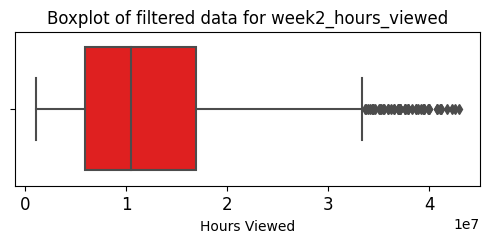

In [31]:
# Create mask
mask = (filtered4_summary_top10_global_weekly['week2_hours_viewed'] != 0)

# Apply mask to filter out rows
filtered5_summary_top10_global_weekly = filtered4_summary_top10_global_weekly[mask]

# Create new boxplot to visualise distribution of variable `week2_hours_viewed`
plt.figure(figsize=(6,2))
plt.title('Boxplot of filtered data for week2_hours_viewed', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'week2_hours_viewed',
            data = filtered5_summary_top10_global_weekly,
            color='red')
plt.xlabel("Hours Viewed")
plt.show()

After removing outliers, we re-examine correlations among the continuous variables to assess any changes in relationships.

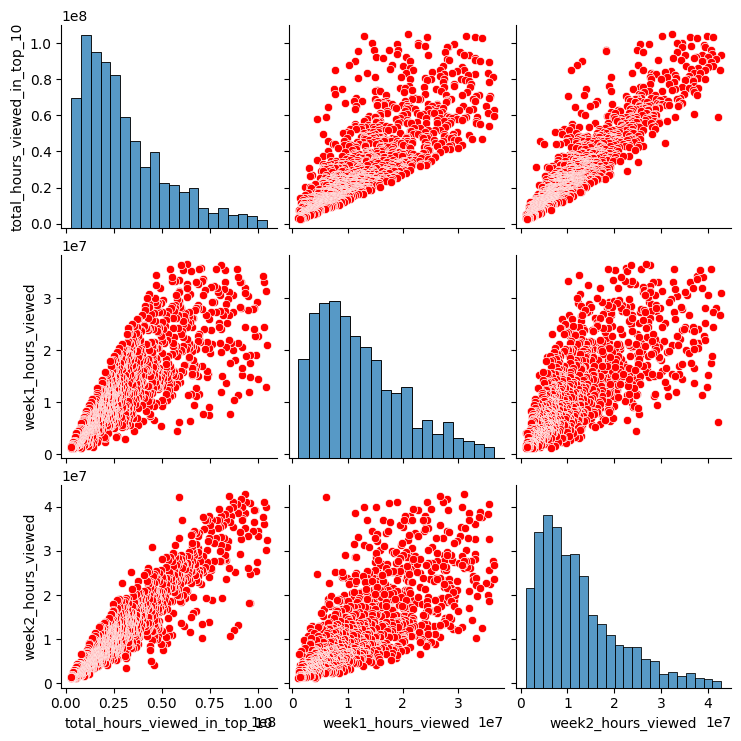

In [32]:
# Create pairwise scatterplots of continuous variables
sns.pairplot(filtered5_summary_top10_global_weekly[[
             'total_hours_viewed_in_top_10',
             'week1_hours_viewed',
             'week2_hours_viewed']],
             plot_kws={'color': 'red'})

# Show the plot
plt.show()

The plots confirm earlier observations: there is a strong positive correlation between **total_hours_viewed_in_top_10** and both **week1_hours_viewed** and **week2_hours_viewed**. Additionally, the strong correlation between **week1_hours_viewed** and **week2_hours_viewed**, suggests potential collinearity, which may need to be addressed during modeling.

#### 2.3.2 Categorical variables
We re-examine correlations involving categorical variables using the filtered dataset with outliers removed.

<Axes: xlabel='category', ylabel='total_hours_viewed_in_top_10'>

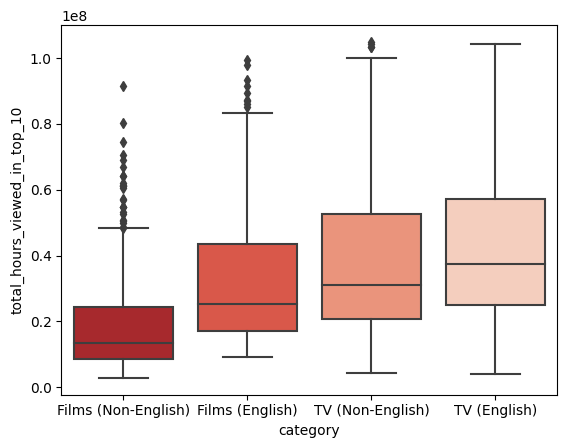

In [33]:
# Assign DataFrame to new variable and reset index
data_to_encode = filtered5_summary_top10_global_weekly.reset_index(drop=True)

# Define the desired order of categories
category_order = ["Films (Non-English)", "Films (English)", "TV (Non-English)", "TV (English)"]

# Create boxplot to show distribution of 'total_hours_viewed_in_top_10' by 'category'
sns.boxplot(x = "category",
            y = "total_hours_viewed_in_top_10",
            data = data_to_encode,
            order=category_order,
            palette='Reds_r')

We observe a clear association between **category** and **total_hours_viewed_in_top_10**. TV shows generally have a higher average **total_hours_viewed_in_top_10** compared to films, with foreign language films performing weakest. This suggests that TV shows may have a broader appeal or benefit from episodic release patterns.

We encode categorical variables using one-hot encoding to ensure that they can be used effectively in the machine learning models. One-hot encoding prevents the model from assuming an ordinal relationship between categorical values.

In [34]:
# Dummy encode categorical values
data = pd.get_dummies(data_to_encode,
                   columns=['category'],
                   drop_first=True)

#### 2.3.3 Boolean variables
We re-examine correlations involving boolean variables using the filtered dataset with outliers removed.

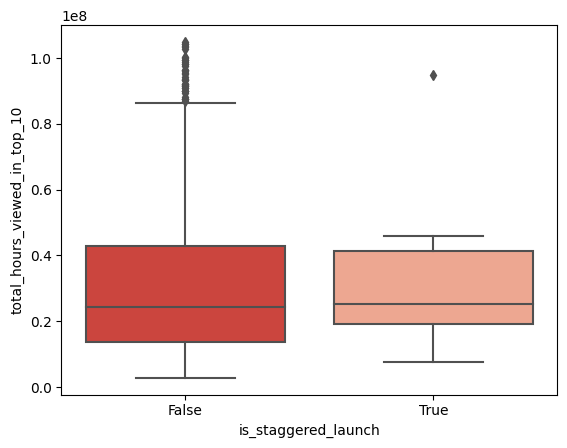

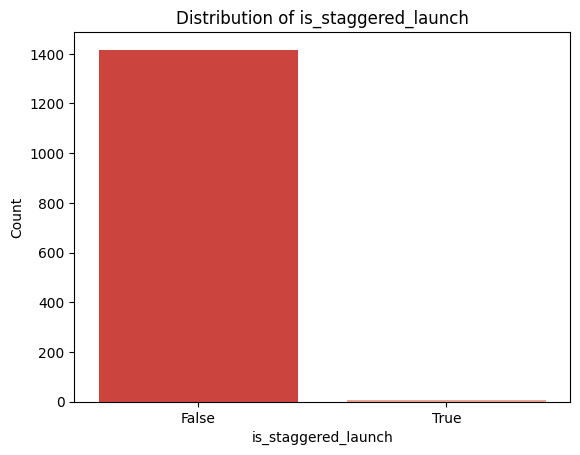

In [35]:
# Create boxplot to show distribution of 'total_hours_viewed_in_top_10' by boolean variable 'is_staggered_launch'
sns.boxplot(x="is_staggered_launch",
            y="total_hours_viewed_in_top_10",
            data=data,
            palette='Reds_r')
plt.show()

# Check class balance for claim_status
sns.countplot(x='is_staggered_launch',
              data=data,
              palette='Reds_r')
plt.title("Distribution of is_staggered_launch")
plt.xlabel('is_staggered_launch')
plt.ylabel('Count')
plt.show()

We observe that **is_staggered_launch** has a very weak correlation with **log_total_hours_viewed_in_top_10** and a highly imbalanced distribution. Based on these findings we will exclude **is_staggered_launch** as it is unlikely to contribute meaningfully to the model's performance.

## 3 Model Construction

### 3.1 Final Feature Selection

We will build four Machine Learning models — Decision Tree, Random Forest, Gradient Boosting and XGBoost regression — to forecast the performance of a Netflix title based on its first two weeks in the Global Top 10 rankings.

| Target ($y$)                      | Features ($x_i$)|
|---------------------------------------------|----------------------------------------|
| **total_hours_viewed_in_top_10** (continuous) |  **week1_hours_viewed** (continuous)  |
|                                             |  **week2_hours_viewed** (continuous)  |
|                                             |  **week1_rank** (ordinal)                                  |
|                                             |  **week2_rank** (ordinal)                                  |
|                                             |  **category** (categorical, one-hot encoded)                                |

### 3.2 Split the data

We assign the target variable and isolate the relevant features that will be used by the Machine Learning models.

In [36]:
# Assign target variable
y = data['total_hours_viewed_in_top_10']

# Isolate the features
X = data[[
    'week1_hours_viewed',
    'week2_hours_viewed',
    'week1_rank',
    'week2_rank',
    'category_Films (Non-English)',
    'category_TV (English)',
    'category_TV (Non-English)'
]]

Split data into training and testing sets, 80/20.

In [37]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [38]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [39]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((853, 7), (285, 7), (285, 7), (853,), (285,), (285,))

### 3.3 Build Models

#### 3.3.1 Decision Tree

Decision trees handle collinearity fairly well, as they independently select the best features at each split. However, high collinearity can lead to overfitting or overly complex trees.

We fit a decision tree regression model to the training set, and hyperparameters are tuned using GridSearchCV, which selects the best model based on the R-squared score.

In [40]:
# Instantiate the decision tree regressor
dt = DecisionTreeRegressor(random_state=0)

# Create a dictionary of hyperparameters to search over
cv_params = {'max_depth': [5, 7, None],                # how deep the tree is allowed to grow
             'max_features': ['sqrt', 0.3, 0.6],       # number of features that each tree randomly selects during training
             'min_samples_leaf': [1, 2],               # minimum number of samples for a leaf node 
             'min_samples_split': [2, 3],              # minimum number of samples that a node must have to split into more nodes
             }

# Define scoring metric for GridSearch
scoring = ['neg_mean_squared_error', 'r2']

# Instantiate the GridSearchCV object for cross-validation
dt_cv = GridSearchCV(dt,                               # decision tree regressor base model
                     cv_params,                        # the hyperparameters that GridSearchCV will tune
                     scoring=scoring,                  # evaluation metrics for model performance
                     cv=5,                             # 5-fold cross-validation
                     refit='r2')                       # best model determined by best R-squared score (r2)

In [41]:
%%time
# Fit the model to the training data
dt_cv.fit(X_train, y_train)

CPU times: user 1.05 s, sys: 2.88 ms, total: 1.06 s
Wall time: 1.06 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': [5, 7, None],
                         'max_features': ['sqrt', 0.3, 0.6],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3]},
             refit='r2', scoring=['neg_mean_squared_error', 'r2'])

In [42]:
# Examine best score according to the refit metric (R-squared)
dt_cv.best_score_

0.8032252609573487

In [43]:
# Examine best parameters
dt_cv.best_params_

{'max_depth': 5,
 'max_features': 0.6,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [44]:
# Access the GridSearch results and convert it to a pandas df
dt_results_df = pd.DataFrame(dt_cv.cv_results_)

#### 3.3.2 Random Forest

Random Forest is an ensemble learning method that constructs multiple decision trees, each built using a random subset of features. This approach helps reduce the model's sensitivity to collinearity, as not all features are considered at each split.

We fit a Random Forest regression model to the training set. Hyperparameters are tuned using GridSearchCV, which selects the best model based on the R-squared score.

In [45]:
# Instantiate the random forest regressor
rf = RandomForestRegressor(random_state=0)

# Create a dictionary of hyperparameters to search over
cv_params = {'max_depth': [5, 7, None],                  # how deep the tree is allowed to grow
             'max_features': ['sqrt', 'log2', 0.3, 0.6], # number of features that each tree randomly selects during training
             'min_samples_leaf': [1, 2],                 # minimum number of samples for a leaf node 
             'min_samples_split': [2, 3],                # minimum number of samples that a node must have to split into more nodes
             'n_estimators': [75, 100, 200],             # the number of trees the model will build in its ensemble
             }

# Define scoring metric for GridSearch
scoring = ['neg_mean_squared_error', 'r2']

# Instantiate the GridSearchCV object for cross-validation
rf_cv = GridSearchCV(rf,                                 # random forest regressor base model
                     cv_params,                          # the hyperparameters that GridSearchCV will tune
                     scoring=scoring,                    # evaluation metrics for model performance
                     cv=5,                               # 5-fold cross-validation
                     refit='r2')                         # best model determined by best R-squared score (r2)

In [46]:
%%time
# Fit the model to the training data
rf_cv.fit(X_train, y_train)

CPU times: user 2min 40s, sys: 587 ms, total: 2min 40s
Wall time: 2min 41s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [5, 7, None],
                         'max_features': ['sqrt', 'log2', 0.3, 0.6],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='r2', scoring=['neg_mean_squared_error', 'r2'])

In [47]:
# Examine best score according to the refit metric (R-squared)
rf_cv.best_score_

0.8602950637973346

In [48]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 0.6,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [49]:
# Access the GridSearch results and convert it to a pandas df
rf_results_df = pd.DataFrame(rf_cv.cv_results_)

#### 3.3.3 Gradient Boosting

Like Random Forest, Gradient Boosting algorithms are not heavily affected by collinearity. They perform well with correlated features by iteratively building weak learners and focusing on the most significant errors.

However, Gradient Boosting algorithms are more sensitive to outliers compared to Random Forest, as they build trees sequentially and may place undue importance on extreme values. Since outliers have been removed, this should not pose a concern.

We fit a Gradient Boosting regression model to the training set, and hyperparameters are tuned using GridSearchCV, which selects the best model based on the R-squared score.

In [50]:
# Instantiate the Gradient Boosting regressor
gb = GradientBoostingRegressor(random_state=0)

# Create a dictionary of hyperparameters to search over
cv_params = {
    'n_estimators': [50, 100, 200],            # the number of boosting stages to perform
    'max_depth': [3, 5, 7],                    # maximum depth of the individual trees
    'learning_rate': [0.01, 0.1, 0.2],         # the step size shrinking the contribution of each tree
    'subsample': [0.8, 0.9, 1.0],              # fraction of samples used for fitting each base learner
    'max_features': ['sqrt', 'log2', 0.3, 0.6] # number of features to consider when looking for the best split
}

# Define scoring metric for GridSearch
scoring = ['neg_mean_squared_error', 'r2']

# Instantiate the GridSearchCV object for cross-validation
gb_cv = GridSearchCV(gb,                          # gradient boosting regressor base model
                     cv_params,                   # the hyperparameters that GridSearchCV will tune
                     scoring=scoring,             # evaluation metrics for model performance
                     cv=5,                        # 5-fold cross-validation
                     refit='r2')                  # best model determined by best R-squared score (r2)

In [51]:
%%time
# Fit the model to the training data
gb_cv.fit(X_train, y_train)

CPU times: user 3min 5s, sys: 48.4 ms, total: 3min 5s
Wall time: 3min 5s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'max_features': ['sqrt', 'log2', 0.3, 0.6],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 0.9, 1.0]},
             refit='r2', scoring=['neg_mean_squared_error', 'r2'])

In [52]:
# Examine best score according to the refit metric (R-squared)
gb_cv.best_score_

0.8581926815462069

In [53]:
# Examine best parameters
gb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'max_features': 0.6,
 'n_estimators': 50,
 'subsample': 1.0}

In [54]:
# Access the GridSearch results and convert it to a pandas df
gb_results_df = pd.DataFrame(gb_cv.cv_results_)

#### 3.3.4 XGBoost
XGBoost, like Gradient Boosting, is relatively resilient to collinearity due to its tree-building approach. However, high collinearity can still lead to model instability or overfitting, so it’s important to consider this during hyperparameter tuning.

XGBoost can be more sensitive to outliers than Random Forest, as it may place too much weight on extreme values during training. But since outliers have been removed, this should not be a major concern.

We fit an XGBoost regression model to the training set, and hyperparameters are tuned using GridSearchCV, which selects the best model based on the R-squared score.

In [55]:
# Instantiate the XGBoost regressor
xgb = XGBRegressor(random_state=0)

# Create a dictionary of hyperparameters to search over
cv_params = {
    'n_estimators': [50, 100, 200],             # the number of boosting stages to perform
    'max_depth': [3, 5, 7],                     # maximum depth of the individual trees
    'learning_rate': [0.01, 0.1, 0.2, 0.3],     # the step size shrinking the contribution of each tree
    'subsample': [0.8, 0.9, 1.0],               # fraction of samples used for fitting each base learner
    'min_child_weight': [1, 2, 3, 4, 5]         # minimum sum of instance weight for child nodes
}

# Define scoring metric for GridSearch
scoring = ['neg_mean_squared_error', 'r2']

# Instantiate the GridSearchCV object for cross-validation
xgb_cv = GridSearchCV(xgb,                      # XGBoost regressor base model
                      cv_params,                # the hyperparameters that GridSearchCV will tune
                      scoring=scoring,          # evaluation metrics for model performance
                      cv=5,                     # 5-fold cross-validation
                      refit='r2')               # best model determined by best R-squared score (r2)

In [56]:
%%time
# Fit the model to the training data
xgb_cv.fit(X_train, y_train)

CPU times: user 14min 37s, sys: 19.8 s, total: 14min 57s
Wall time: 3min 50s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [3, 5, 7],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 0.9, 1.0]},
             refit='r2', scoring=['neg_mean_squared_error', 'r2'])

In [57]:
# Examine best score according to the refit metric (R-squared)
xgb_cv.best_score_

0.861350827886658

In [58]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 4,
 'n_estimators': 50,
 'subsample': 1.0}

In [59]:
# Access the GridSearch results and convert it to a pandas df
xgb_results_df = pd.DataFrame(xgb_cv.cv_results_)

## 4 Model Evaluation
### 4.1 Results and evaluation
#### 4.1.1 Model selection
We evaluate candidate models on the validation data to select the champion model.

In [60]:
# Function to calculate evaluation metrics
def get_model_metrics(model, X_data, y_data):
    # Get predictions
    y_pred = model.predict(X_data)
    
    # R-squared
    r2 = r2_score(y_data, y_pred)
    
    # Mean Squared Error
    mse = mean_squared_error(y_data, y_pred)

    # Root Mean Squared Error
    rmse = np.sqrt(mse)
    
    # Adjusted R-squared
    n = len(y_data)  # number of observations
    p = X_data.shape[1]  # number of features
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    # Store metrics in a dictionary
    metrics = {
        "R-squared": r2,
        "Adjusted R-squared": adj_r2,
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse,
    }
    
    return metrics

# Machine Learning models
models = {
    "Decision Tree":     dt_cv.best_estimator_,
    "Random Forest":     rf_cv.best_estimator_,
    "Gradient Boosting": gb_cv.best_estimator_,
    "XGBoost":           xgb_cv.best_estimator_
}

# Create an empty list to store metrics for each model
results = []

# Loop over each model and calculate metrics
for model_name, model in models.items():
    metrics = get_model_metrics(model, X_val, y_val)
    metrics["Model"] = model_name
    results.append(metrics)

# Convert the list of results into a pandas DataFrame
results_df = pd.DataFrame(results)

# Reorder columns for better readability
results_df = results_df[["Model", "R-squared", "Adjusted R-squared", "Mean Squared Error", "Root Mean Squared Error"]]

# Display the results
results_df

,Model,R-squared,Adjusted R-squared,Mean Squared Error,Root Mean Squared Error
0,Decision Tree,0.800488,0.795447,9.356470e+13,9.672885e+06
1,Random Forest,0.855827,0.852184,6.761260e+13,8.222688e+06
2,Gradient Boosting,0.851449,0.847695,6.966581e+13,8.346604e+06
3,XGBoost,0.851936,0.848195,6.943718e+13,8.332898e+06


The Random Forest regression model achieves the lowest *Root Mean Squared Error* and the highest *R-squared*, making it the best-performing model.

#### 4.1.2 Champion Model Evaluation

We evaluate the champion model using the test dataset.

In [61]:
# Use champion model to predict on test data
get_model_metrics(rf_cv.best_estimator_, X_test, y_test)

{'R-squared': 0.8830309221757284,
 'Adjusted R-squared': 0.8800750249021909,
 'Mean Squared Error': 51173213530027.984,
 'Root Mean Squared Error': 7153545.521629675}

An *R-squared* of 0.883 indicates that 88.3% of the variability in **total_hours_viewed_in_Top_10** is explained by the model. The near-identical *Adjusted R-squared* suggests that the model generalizes well without excessive or redundant predictors.

However, the high *Root Mean Squared Error* (7.15 million hours) indicates that while the model captures general trends effectively, individual predictions exhibit significant variance.

To further illustrate this, we get predictions on the test dataset and visualise the model's performance using bar charts.

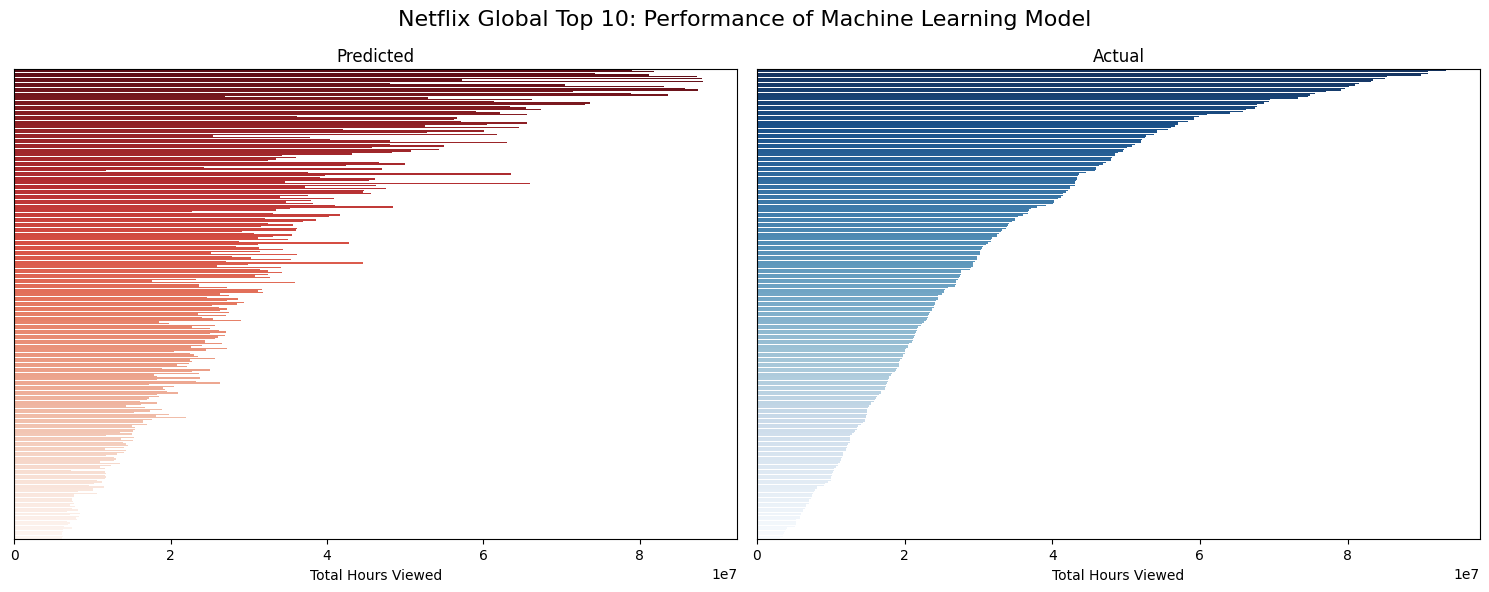

In [62]:
# Get predictions on test dataset
y_pred = rf_cv.best_estimator_.predict(X_test)

# Convert y_pred to a DataFrame with the same index as y_test
y_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=["y_pred"])

# Concatenate predictions and actual values
model_results = pd.concat([y_test, y_pred_df], axis=1)

# Sort by total hours viewed
model_results = model_results.sort_values(by='total_hours_viewed_in_top_10', ascending=False)

# Reset index to make it a column for plotting
model_results = model_results.reset_index()
model_results['id'] = model_results.index.astype(str)

# Create figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot predicted total hours viewed
sns.barplot(
    x="y_pred", 
    y="id", 
    data=model_results,
    palette="Reds_r",
    ax=axes[0]
)
axes[0].set_xlabel("Total Hours Viewed")
axes[0].set_ylabel("")
axes[0].set_title("Predicted")
axes[0].set_yticks([])

# Plot actual total hours viewed
sns.barplot(
    x="total_hours_viewed_in_top_10", 
    y="id", 
    data=model_results,
    palette="Blues_r",
    ax=axes[1]
)
axes[1].set_xlabel("Total Hours Viewed")
axes[1].set_ylabel("")
axes[1].set_title("Actual")
axes[1].set_yticks([])

# Add overall title
fig.suptitle("Netflix Global Top 10: Performance of Machine Learning Model", fontsize=16)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('ml_model_performance1.png', format='png')

# Show the plots
plt.show()


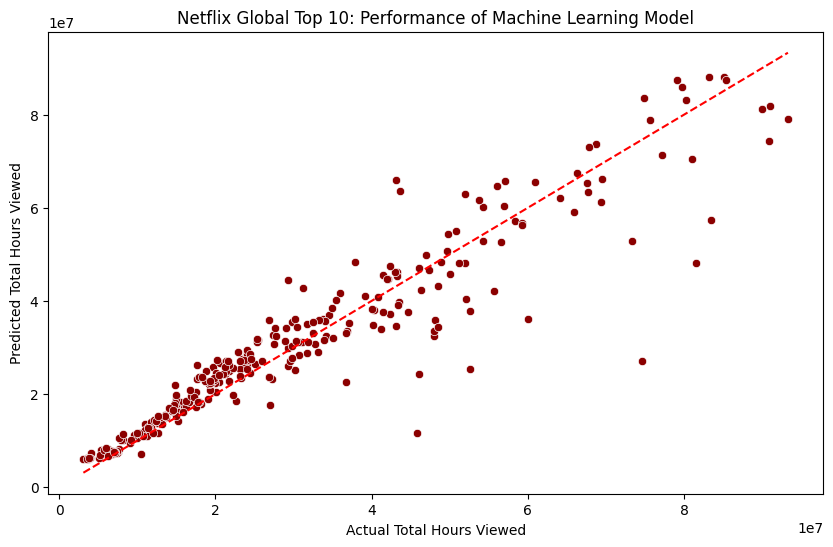

In [63]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='darkred')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Netflix Global Top 10: Performance of Machine Learning Model')
plt.xlabel('Actual Total Hours Viewed')
plt.ylabel('Predicted Total Hours Viewed')

# Save the plot as a PNG file
plt.savefig('ml_model_performance2.png', format='png')

# Show the plot
plt.show()

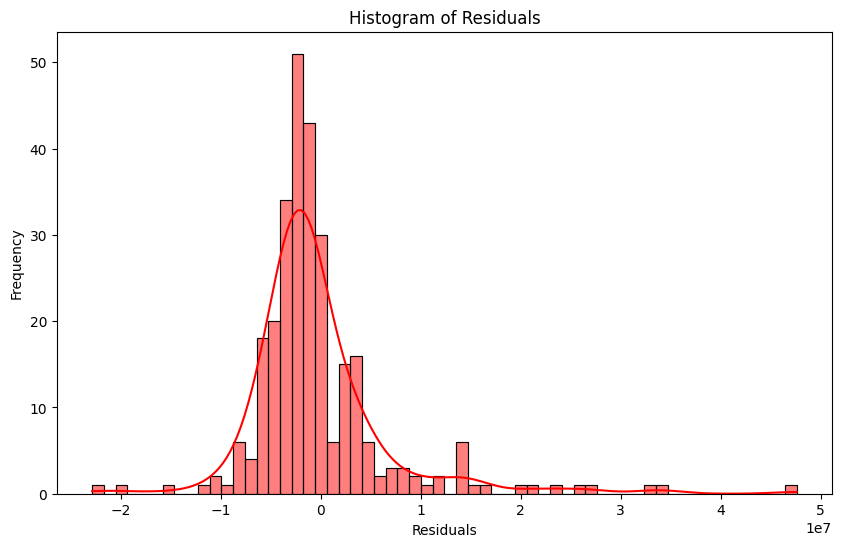

In [64]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='red', bins=60)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

#### 4.1.3 Retrain Champion Model
To maximise predictive power, we retrain the Random Forest model using the entire dataset.

In [65]:
%%time
# Fit the champion model to the entire dataset
rf_cv.fit(X, y)

CPU times: user 3min 8s, sys: 523 ms, total: 3min 9s
Wall time: 3min 9s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [5, 7, None],
                         'max_features': ['sqrt', 'log2', 0.3, 0.6],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='r2', scoring=['neg_mean_squared_error', 'r2'])

We save the retrained model using pickle for future use.

In [66]:
# Pickle the model
with open('rf_cv_model.pickle', 'wb') as to_write:
    pickle.dump(rf_cv, to_write)

#### 4.1.4 Feature Importance
We visualise the feature importance to gain insights into which features have the greatest impact on the model's predictions.

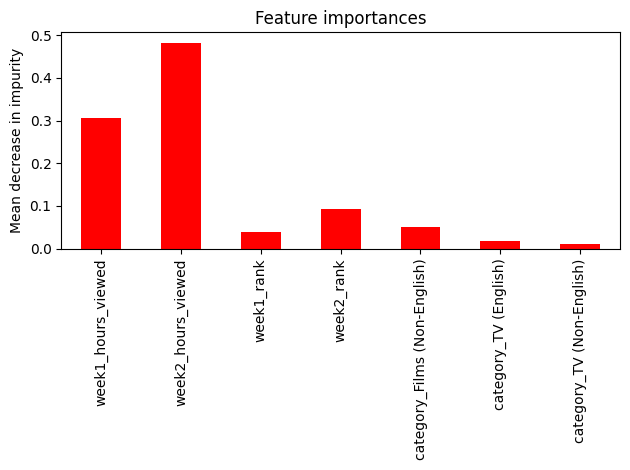

In [67]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax, color='red')
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

The most predictive features were:
* **week2_hours_viewed** (most significant)
* **week1_hours_viewed**
* **week2_rank**

We observe that **category** had minor influence.

Overall this suggests that week 2 viewership is the strongest indicator of future Netflix Top 10 performance. For TV series, this likely reflects strong audience retention, as engaged viewers continue watching multiple episodes. For films, the effect may be different, possibly indicating word-of-mouth growth or sustained interest beyond the initial release.



### 4.2 Conclusion

We developed and evaluated four machine learning models to predict the future performance of Netflix Global Top 10 titles using early ranking data. All models outperformed the previous [multiple linear regression model](https://www.kaggle.com/code/davidpbriggs/netflix-global-top-10-performance-predictor) we developed.

The Random Forest regression model performed best, explaining 88.3% of the variance in **total_hours_viewed_in_Top_10**. However, its high *Root Mean Squared Error* (7.15 million hours) indicates significant prediction errors, limiting its accuracy in forecasting exact viewership figures.

Key observations from our analysis include:
* TV shows generally have higher total viewership than films
* Foreign-language films tend to perform the weakest
* Week 2 viewership is the strongest predictor of long-term success in the Netflix Global Top 10